In [76]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# Para AllKNN (elimina ruido); si no está instalado, instala con pip
from imblearn.under_sampling import AllKNN

# Ajustes de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Estilo de gráficos
sns.set(style="whitegrid")


In [77]:
csv_path = 'data/hotel_bookings.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"El archivo '{csv_path}' no se ha encontrado.")

# Cargar CSV
df = pd.read_csv(csv_path)

# Mostrar primeras filas
print("=== Primeras filas del DataFrame ===")
print(df.head(), "\n")


=== Primeras filas del DataFrame ===
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     0 

In [78]:
# Mostrar las estadísticas descriptivas del DataFrame
print(df.describe())

         is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000            

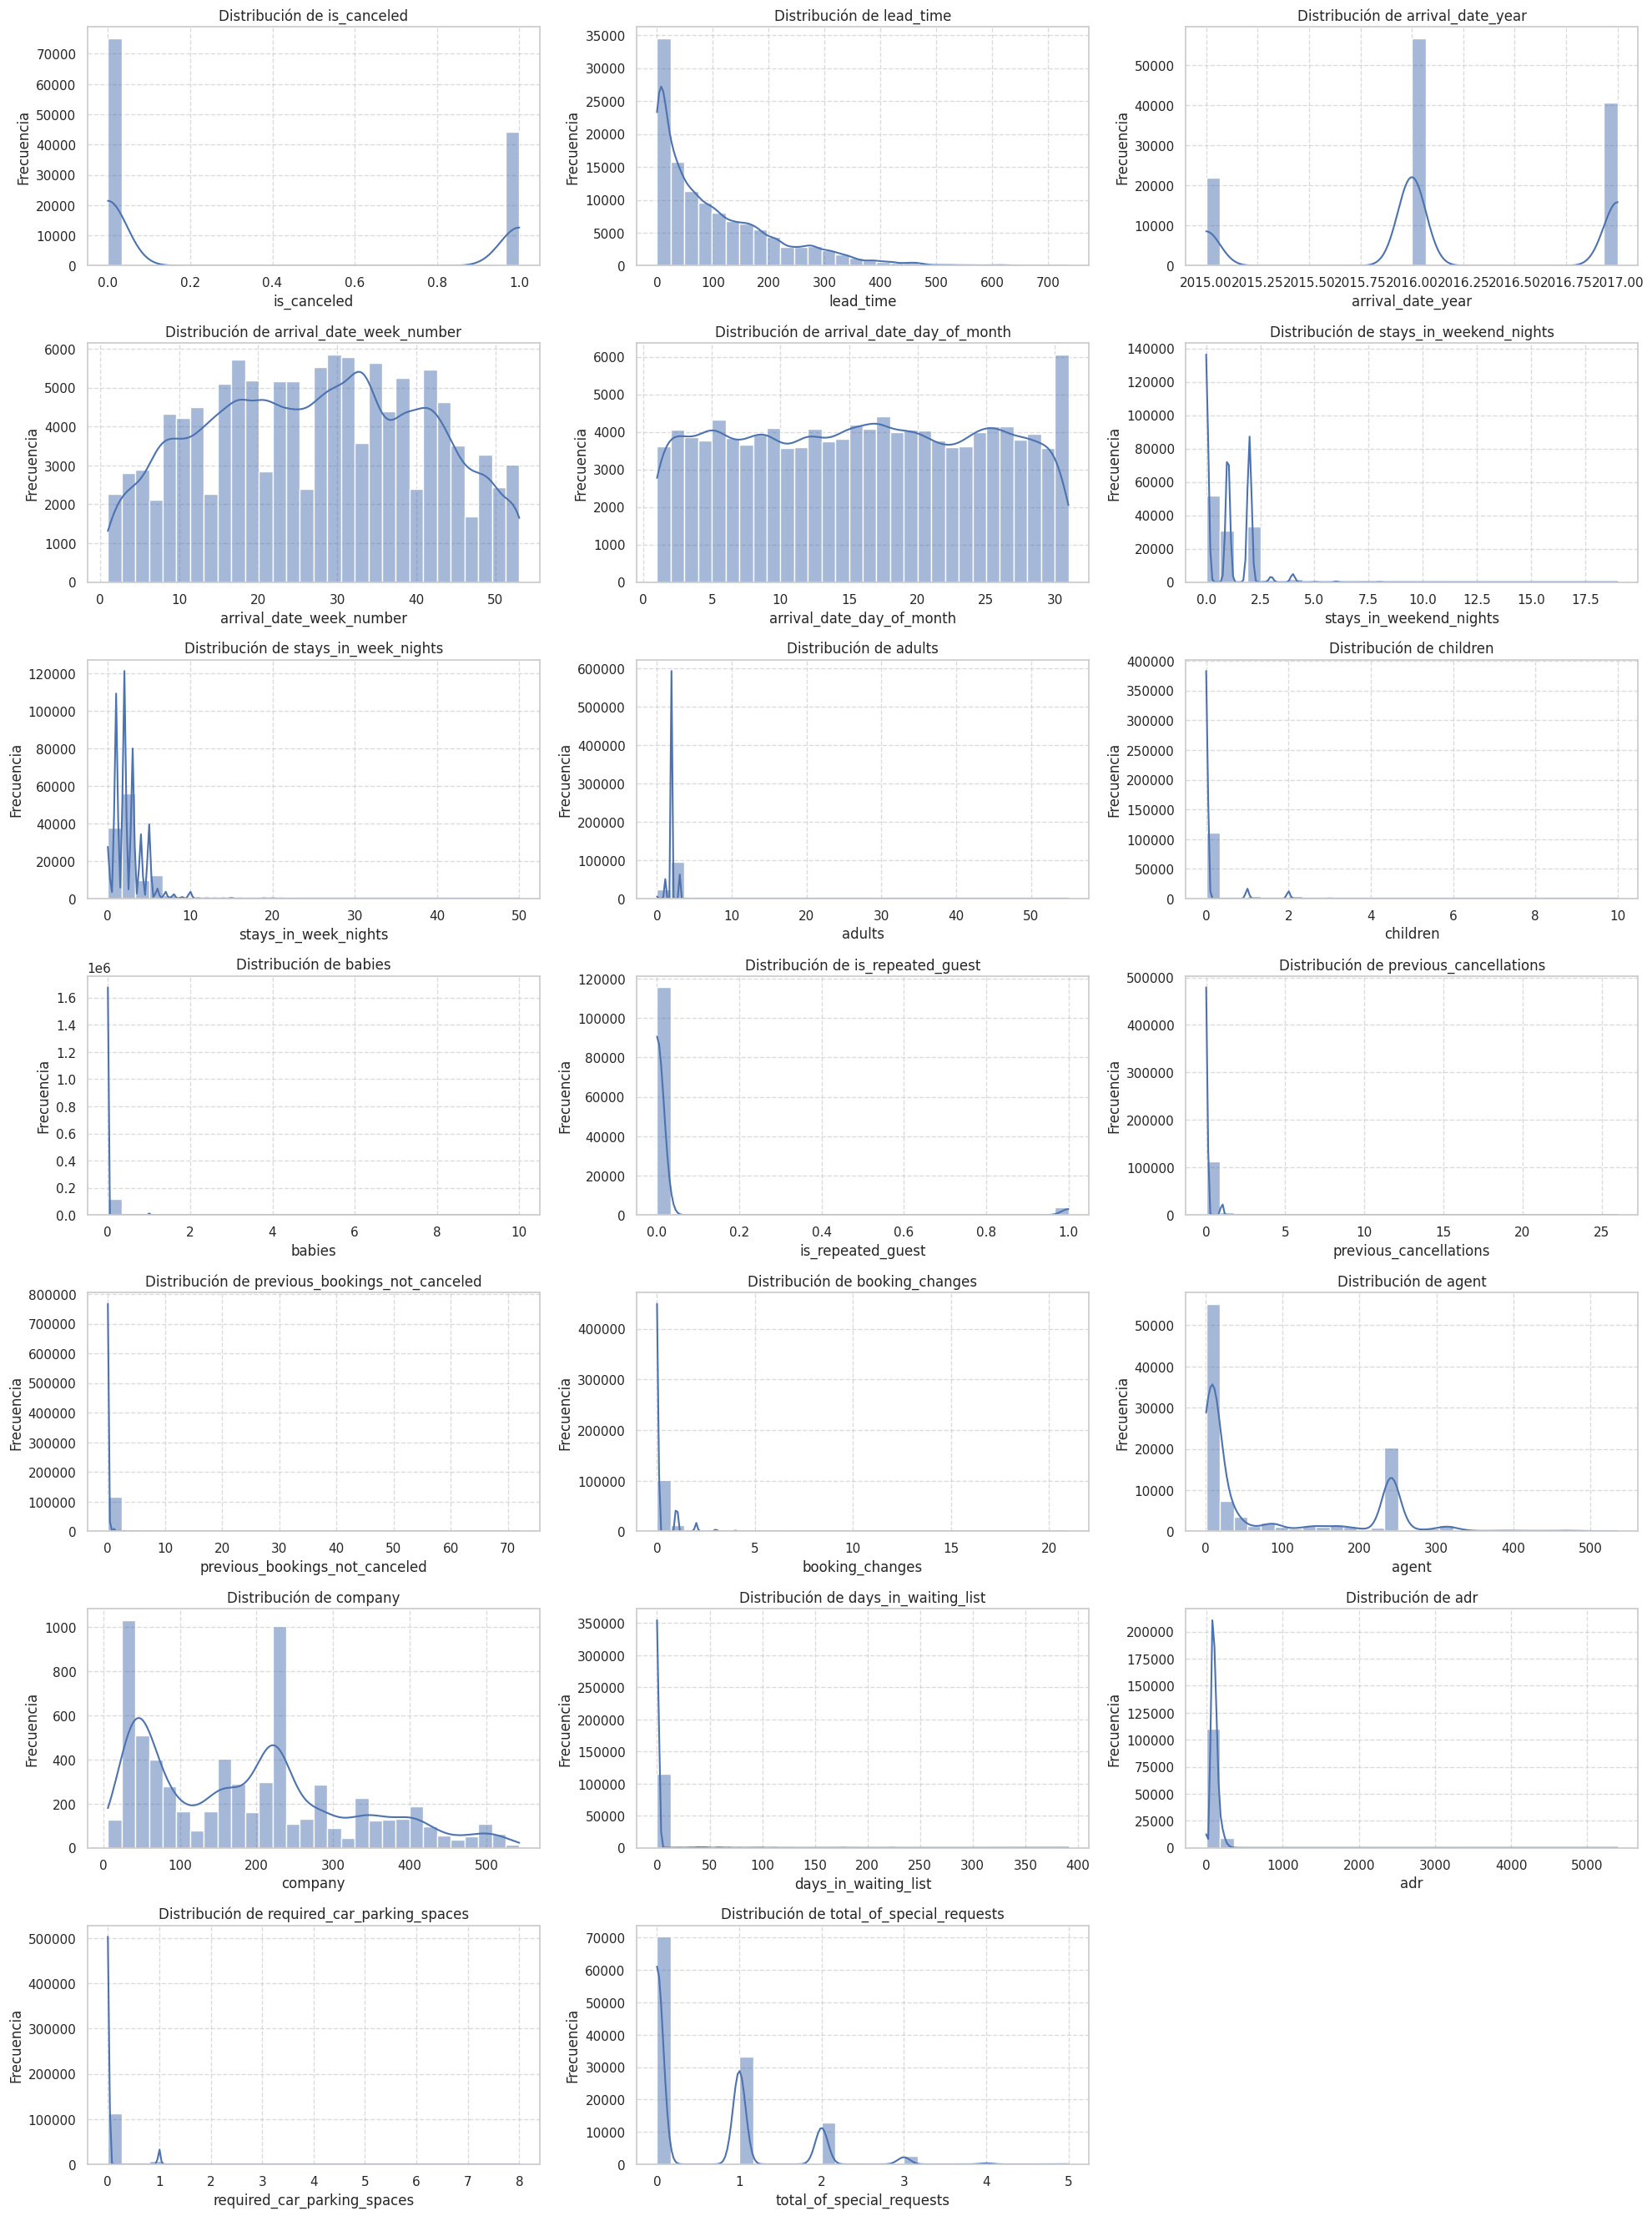

In [79]:
# Configuración de los gráficos
plt.figure(figsize=(20, 30))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Generar histogramas para cada columna numérica
for i, column in enumerate(numeric_cols, 1):
    plt.subplot(8, 3, i)
    sns.histplot(df[column], kde=True, bins=30)  # KDE muestra la línea de densidad
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()  # Ajustar el espaciado entre gráficos
plt.show()

In [80]:
# Mostrar información general del DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [81]:
# Miramos valores nulos en el DataFrame
print(df.isnull().sum())

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [82]:
# Eliminar columnas irrelevantes o con muchos nulos
df.drop(columns=['reservation_status', 'company'], inplace=True, errors='ignore')

# Imputaciones “de negocio”:
# - 'agent': 0 significa “sin agente”
# - 'children': 0 significa “sin niños”
# - 'country': 'Unknown' para casos faltantes
df['agent']    = df['agent'].fillna(0).astype(int)
df['children'] = df['children'].fillna(0).astype(int)
df['country']  = df['country'].fillna('Unknown').astype('category')

# Convertir 'reservation_status_date' a datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], format='%Y-%m-%d', errors='coerce')

# Volver a comprobar nulos tras imputaciones
print("=== Conteo de nulos tras imputaciones ===")
print(df.isnull().sum(), "\n")


=== Conteo de nulos tras imputaciones ===
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                   

In [83]:
# Mostrar los tipos de datos de cada columna
print(df.dtypes)

hotel                                     object
is_canceled                                int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                   int64
babies                                     int64
meal                                      object
country                                 category
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type  

In [84]:
# Cálculo de duplicados
total_filas = len(df)
filas_unicas = len(df.drop_duplicates())
duplicadas_count = df.duplicated().sum()

print(f"Total de filas:      {total_filas}")
print(f"Filas únicas:        {filas_unicas}")
print(f"Filas duplicadas:    {duplicadas_count}\n")

# Agrupar por todas las columnas para ver combinaciones idénticas
# Usar value_counts en lugar de groupby para evitar el ValueError de “espacio de producto”
row_counts = df.value_counts()                  # devuelve una Serie indexada por tuplas de fila
duplicated_counts = row_counts[row_counts > 1]

# Top 10 combinaciones idénticas
top_duplicated = duplicated_counts.head(10).reset_index(name='count')
print("Top 10 combinaciones idénticas:")
print(top_duplicated)

# Distribución de repeticiones
distribution = duplicated_counts.value_counts().sort_index()
print("Distribución de repeticiones:")
for veces, num_combinaciones in distribution.items():
    print(f" - Aparece {veces} veces → {num_combinaciones} combinaciones diferentes")

Total de filas:      119390
Filas únicas:        87387
Filas duplicadas:    32003

Top 10 combinaciones idénticas:
        hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  City Hotel            1        277               2016           November   
1  City Hotel            1         68               2016           February   
2  City Hotel            1        188               2016               June   
3  City Hotel            1        158               2016                May   
4  City Hotel            1         34               2015           December   
5  City Hotel            1         28               2017              March   
6  City Hotel            1        156               2017              April   
7  City Hotel            1         38               2017            January   
8  City Hotel            1         71               2016               June   
9  City Hotel            1        305               2016           November   

   arrival_date

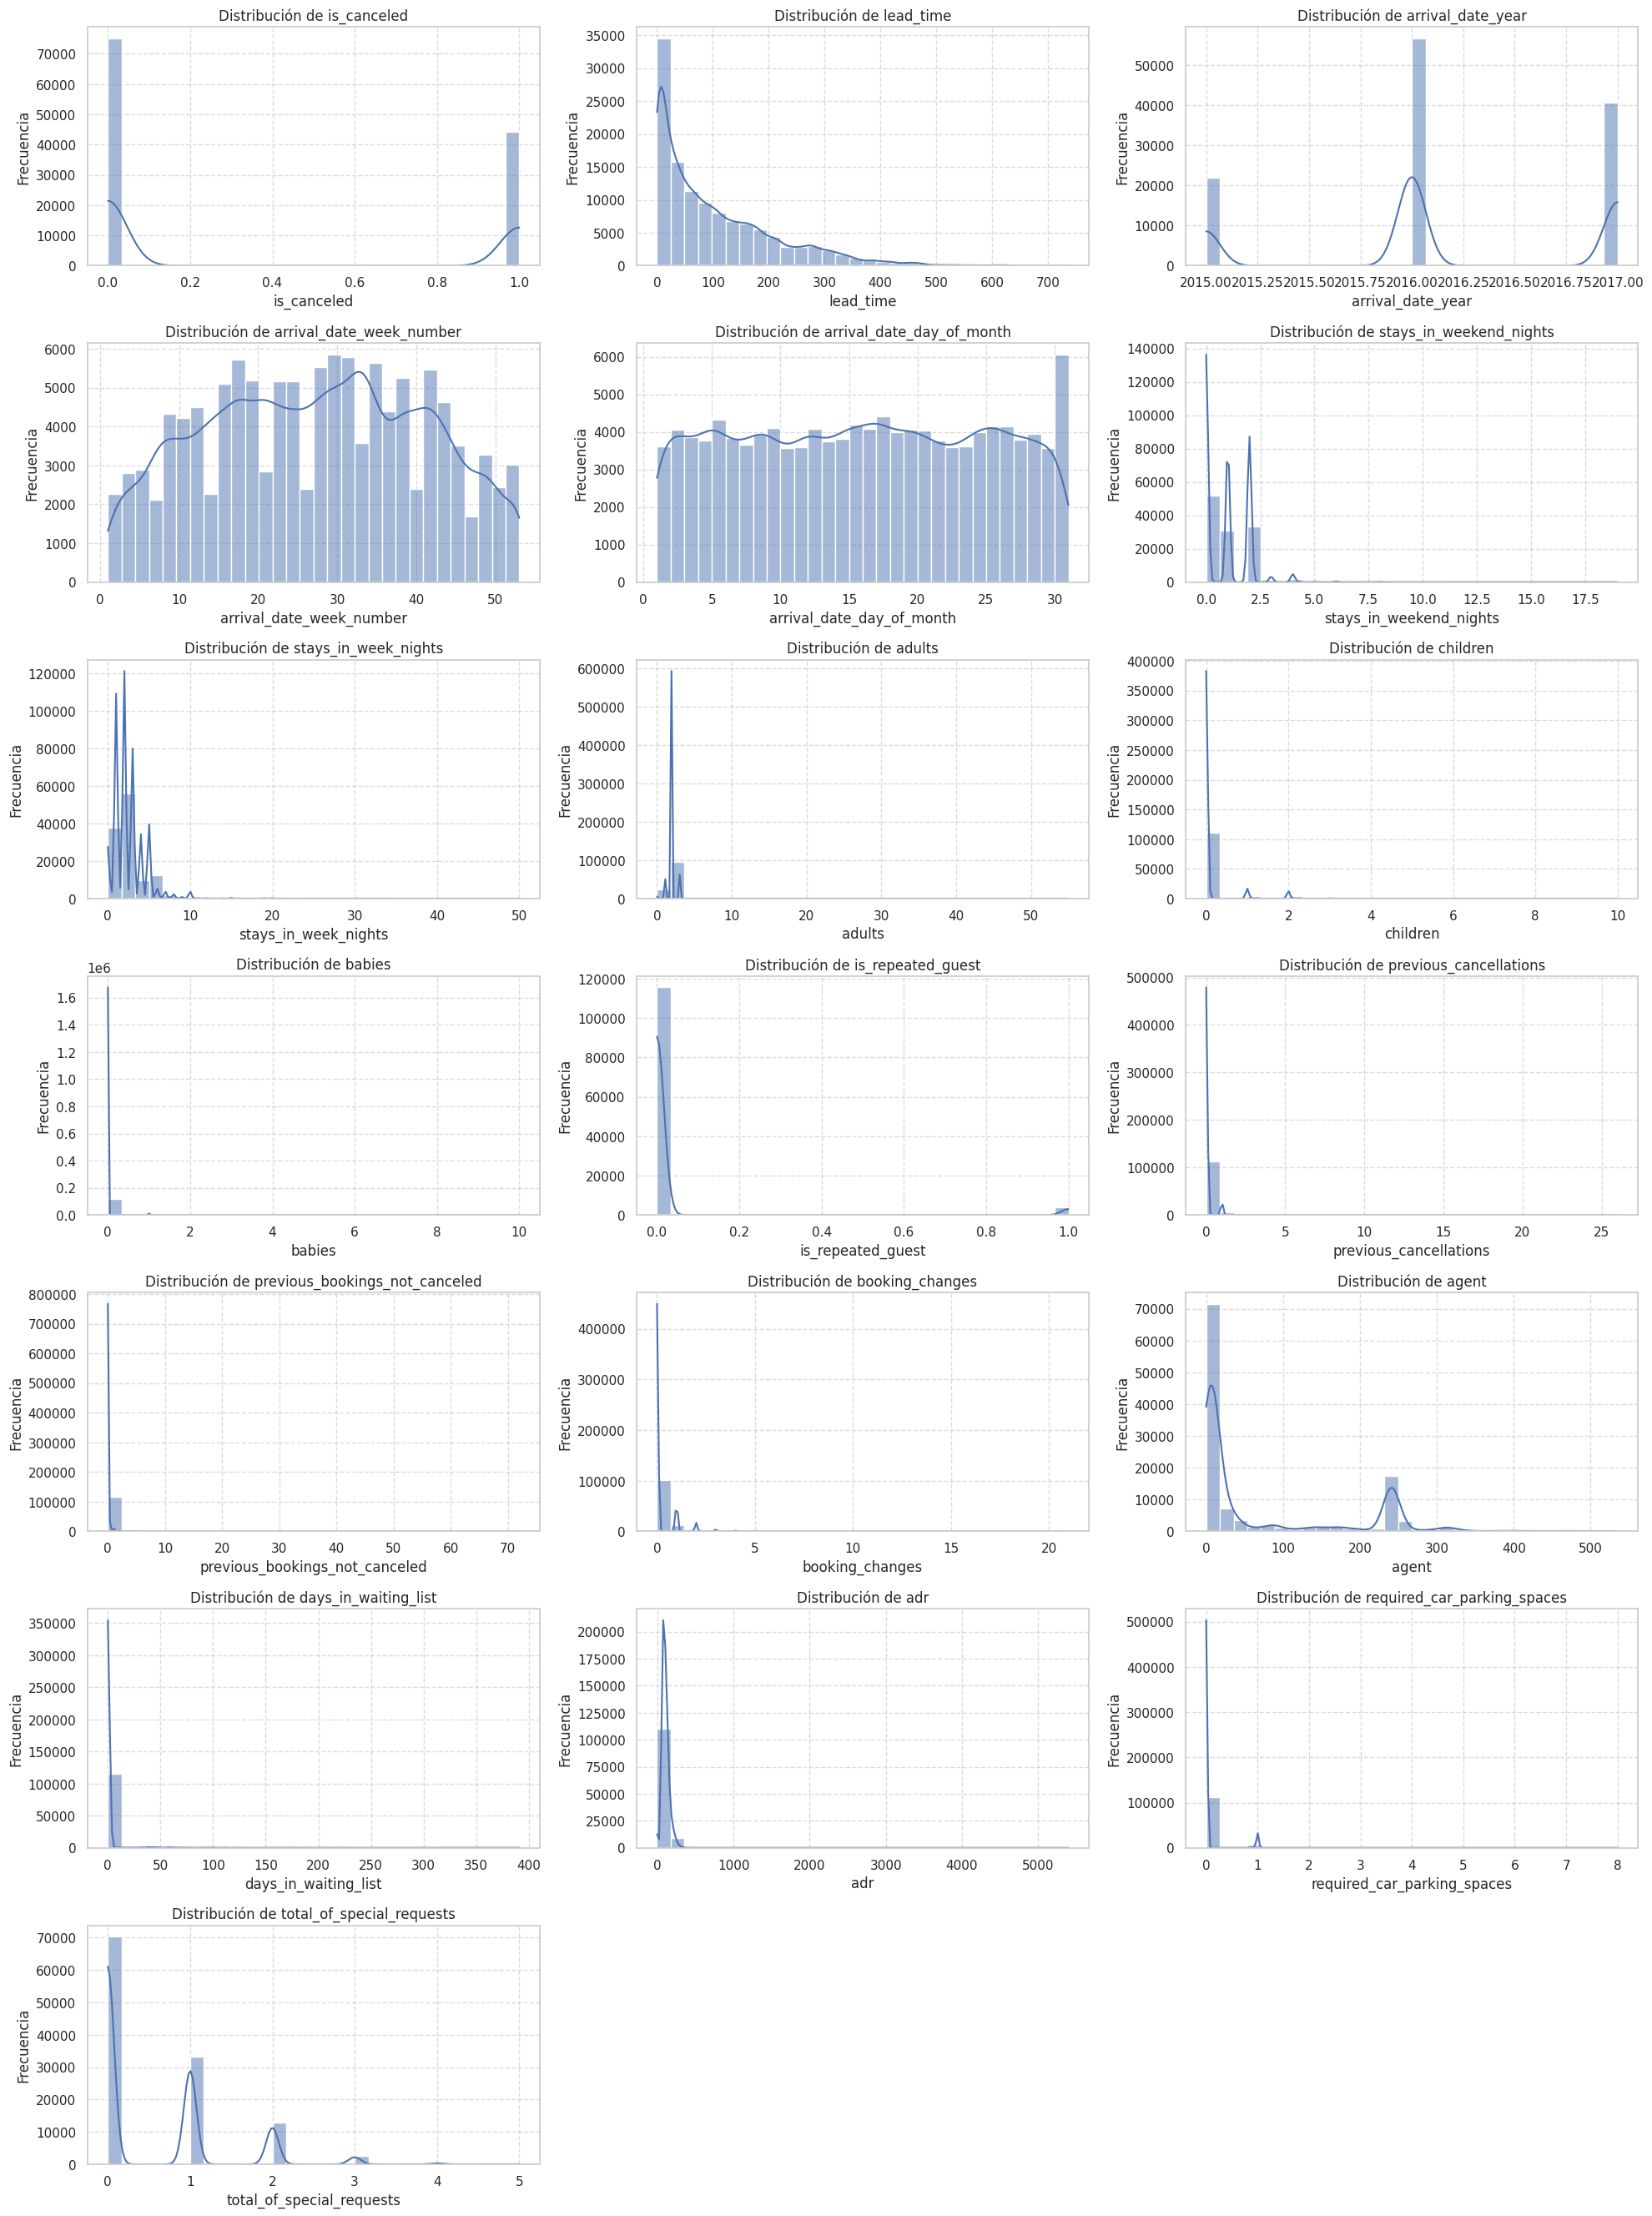

=== Correlaciones fuertes (> 0.5 o < -0.5) entre variables numéricas ===
                    level_0                   level_1         0
3         arrival_date_year  arrival_date_week_number -0.540561
4  arrival_date_week_number         arrival_date_year -0.540561 



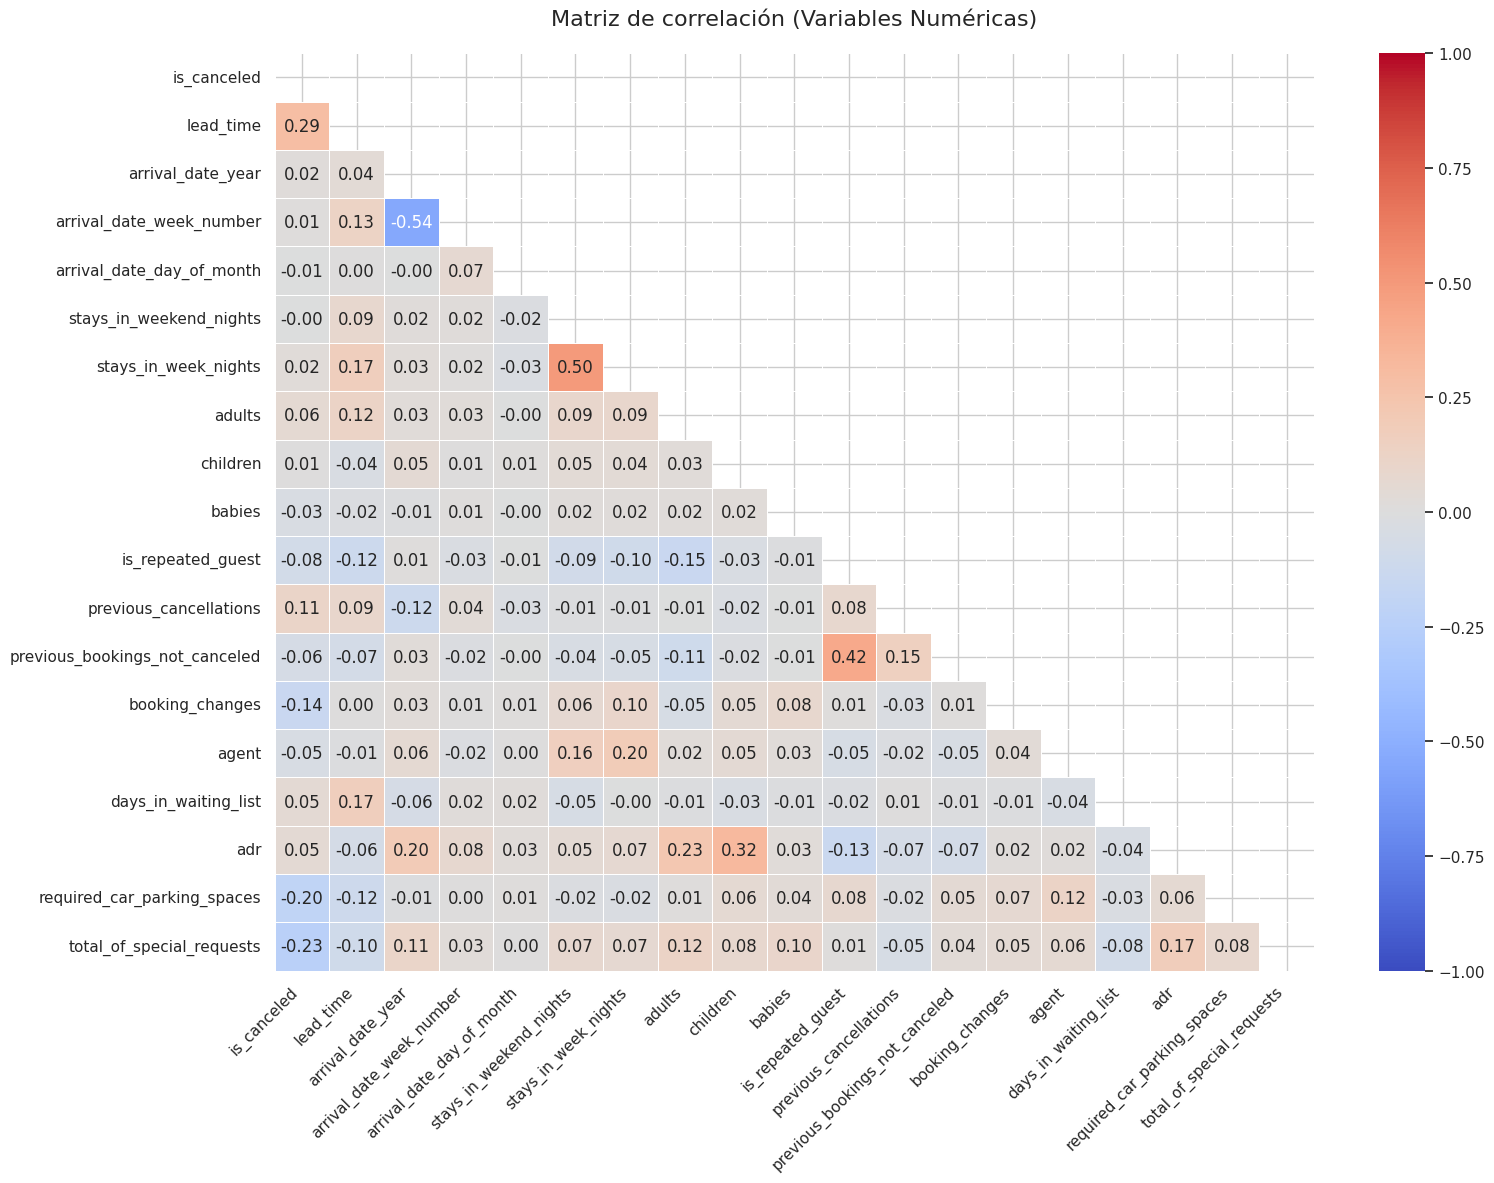

In [85]:
# Seleccionar columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Histogramas
plt.figure(figsize=(20, 30))
for i, column in enumerate(numeric_cols, 1):
    plt.subplot(8, 3, i)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Matriz de correlación
corr_matrix = df[numeric_cols].corr()
strong_corr = corr_matrix[abs(corr_matrix) > 0.5].stack().reset_index()
strong_corr = strong_corr[strong_corr['level_0'] != strong_corr['level_1']]

print("=== Correlaciones fuertes (> 0.5 o < -0.5) entre variables numéricas ===")
print(strong_corr.sort_values(0, ascending=False).drop_duplicates(), "\n")

# Heatmap de correlación
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title("Matriz de correlación (Variables Numéricas)", pad=20, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Muchos valores duplicados, por lo que deducimos que no se deben a confusiones y que son únicos. (No hay columnas identificativas)

In [86]:
# Mostrar los tipos de datos de cada columna
print(df.dtypes)

hotel                                     object
is_canceled                                int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                   int64
babies                                     int64
meal                                      object
country                                 category
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type  

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Copia del DataFrame original
df_assoc = df.copy()

# Elegimos solo columnas relevantes y categóricas de baja cardinalidad
cols = [
    'hotel', 'arrival_date_month', 'meal', 'market_segment',
    'distribution_channel', 'is_repeated_guest', 'reserved_room_type',
    'assigned_room_type', 'deposit_type', 'customer_type', 'is_canceled'
]

# Convertimos a string
df_assoc = df_assoc[cols].astype(str)

# Creamos transacciones tipo "col=valor"
transactions = df_assoc.apply(lambda row: [f"{col}={row[col]}" for col in df_assoc.columns], axis=1).tolist()

# Codificamos las transacciones
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apriori con menor uso de memoria
frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True)

# Generamos reglas
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Limitar a máximo 2 antecedentes y 2 consecuentes
rules = rules[(rules['antecedents'].apply(len) <= 2) & (rules['consequents'].apply(len) <= 2)]

# Filtramos reglas que predicen cancelación
rules_cancel = rules[rules['consequents'].astype(str).str.contains("is_canceled=1")]

# Mostramos reglas más relevantes
print(rules_cancel[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))


                                             antecedents  \
68485  (customer_type=Transient, hotel=City Hotel, as...   
65924  (customer_type=Transient, hotel=City Hotel, ma...   
65893  (customer_type=Transient, hotel=City Hotel, is...   
68419  (assigned_room_type=A, is_repeated_guest=0, ma...   
53709  (customer_type=Transient, hotel=City Hotel, ma...   
60482  (customer_type=Transient, hotel=City Hotel, as...   
68511  (reserved_room_type=A, customer_type=Transient...   
68453  (is_repeated_guest=0, market_segment=Groups, r...   
60497  (reserved_room_type=A, customer_type=Transient...   
68530  (customer_type=Transient, hotel=City Hotel, ma...   

                                             consequents   support  \
68485  (is_repeated_guest=0, is_canceled=1, reserved_...  0.050909   
65924  (is_repeated_guest=0, is_canceled=1, distribut...  0.050063   
65893  (deposit_type=Non Refund, meal=BB, distributio...  0.050063   
68419  (reserved_room_type=A, meal=BB, deposit_type=N...  0

In [88]:
from collections import Counter

# Definir objetivo y características
target = 'is_canceled'
X = df.drop(columns=[target]).copy()
y = df[target].copy()

# 'reservation_status_date' a entero ordinal (para que AllKNN lo acepte)
X['reservation_status_date'] = X['reservation_status_date'].map(lambda dt: dt.toordinal())

# Separar numéricas y categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Imputar numéricas faltantes (si quedaran) con mediana
imp_num = SimpleImputer(strategy='median')
X_num = pd.DataFrame(imp_num.fit_transform(X[num_cols]), columns=num_cols, index=X.index)

# Imputar categóricas faltantes con la moda
imp_cat = SimpleImputer(strategy='most_frequent')
X_cat = pd.DataFrame(imp_cat.fit_transform(X[cat_cols]), columns=cat_cols, index=X.index)

# Concatenar numéricas + categóricas
X_imputed = pd.concat([X_num, X_cat], axis=1)

# Label Encoding solo en columnas categóricas
X_encoded = X_imputed.copy()
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    le_dict[col] = le

print("=== Forma antes de AllKNN ===")
print(" X:", X_encoded.shape, " y:", y.shape, "\n")

# Aplicar AllKNN para eliminar muestras ruidosas
allknn = AllKNN()
X_res, y_res = allknn.fit_resample(X_encoded, y)

print("=== Forma después de AllKNN ===")
print(" X_res:", X_res.shape, " y_res:", y_res.shape, "\n")

print("=== Distribución de clases antes de AllKNN ===")
print(Counter(y))
print("=== Distribución de clases después de AllKNN ===")
print(Counter(y_res), "\n")

=== Forma antes de AllKNN ===
 X: (119390, 29)  y: (119390,) 

=== Forma después de AllKNN ===
 X_res: (103030, 29)  y_res: (103030,) 

=== Distribución de clases antes de AllKNN ===
Counter({0: 75166, 1: 44224})
=== Distribución de clases después de AllKNN ===
Counter({0: 58806, 1: 44224}) 



In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Reconstruir DataFrame a partir de X_res para facilitar selección de características
df_res = pd.DataFrame(X_res, columns=X_encoded.columns)
df_res[target] = y_res.values

# Identificar numéricas y categóricas sobre el dataset remuestreado
numeric_features = df_res.select_dtypes(include=['int64', 'float64']).columns.drop(target).tolist()
categorical_features = df_res.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocesador: escalado para numéricas & OneHot para categóricas
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    df_res.drop(columns=[target]),
    df_res[target],
    test_size=0.2,
    stratify=df_res[target],
    random_state=42
)

def evaluate_with_explain(model, name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Validación cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
    roc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')

    print(f"\n--- {name} ---")
    print(f"CV F1 Scores:        {np.round(f1_scores, 3)}, Mean: {f1_scores.mean():.3f}")
    print(f"CV ROC-AUC Scores:   {np.round(roc_scores, 3)}, Mean: {roc_scores.mean():.3f}")

    # Entrenar en train completo y evaluar en test
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else np.zeros(len(y_test))

    print(f"Test F1:          {f1_score(y_test, y_pred):.3f}")
    print(f"Test ROC-AUC:     {roc_auc_score(y_test, y_prob):.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

       # Explicabilidad: coeficientes o importancias
    clf = pipeline.named_steps['classifier']
    feature_names_num = numeric_features

    # Solo intentar OneHotEncoder si hay categóricas
    if len(categorical_features) > 0:
        ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
        feature_names_cat = list(ohe.get_feature_names_out(categorical_features))
    else:
        feature_names_cat = []

    all_feature_names = feature_names_num + feature_names_cat

    if hasattr(clf, 'coef_'):
        coefs = clf.coef_[0]
        coef_df = pd.DataFrame({
            'Feature': all_feature_names,
            'Coefficient': coefs
        })
        print(f"\n{name} - Principales coeficientes:")
        display(coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(10))
    elif hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
        imp_df = pd.DataFrame({
            'Feature': all_feature_names,
            'Importance': importances
        })
        print(f"\n{name} - Principales importancias:")
        display(imp_df.sort_values(by='Importance', ascending=False).head(10))


# Evaluar todos los modelos
evaluate_with_explain(LogisticRegression(max_iter=1000), "Regresión Logística")
evaluate_with_explain(DecisionTreeClassifier(random_state=42), "Árbol de Decisión")
evaluate_with_explain(RandomForestClassifier(random_state=42), "Random Forest")
evaluate_with_explain(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), "XGBoost")
evaluate_with_explain(GaussianNB(), "Naive Bayes")


--- Regresión Logística ---
CV F1 Scores:        [0.939 0.938 0.939 0.933 0.94 ], Mean: 0.938
CV ROC-AUC Scores:   [0.989 0.987 0.988 0.985 0.986], Mean: 0.987
Test F1:          0.943
Test ROC-AUC:     0.989
Confusion Matrix:
[[11717    44]
 [  918  7927]]

Regresión Logística - Principales coeficientes:


,Feature,Coefficient
1,arrival_date_year,52.941580
18,reservation_status_date,-46.543342
2,arrival_date_week_number,19.083095
16,required_car_parking_spaces,-3.870177
10,previous_cancellations,0.971324
22,country,0.606923
27,deposit_type,0.514337
26,assigned_room_type,-0.411048
25,reserved_room_type,0.378600
5,stays_in_week_nights,0.243933



--- Árbol de Decisión ---
CV F1 Scores:        [0.934 0.927 0.931 0.927 0.927], Mean: 0.929
CV ROC-AUC Scores:   [0.942 0.936 0.94  0.936 0.936], Mean: 0.938
Test F1:          0.933
Test ROC-AUC:     0.941
Confusion Matrix:
[[11203   558]
 [  625  8220]]

Árbol de Decisión - Principales importancias:


,Feature,Importance
27,deposit_type,0.214908
18,reservation_status_date,0.164752
2,arrival_date_week_number,0.113397
22,country,0.100271
0,lead_time,0.093780
23,market_segment,0.050156
17,total_of_special_requests,0.042462
15,adr,0.031182
1,arrival_date_year,0.029371
13,agent,0.025680
